In [1]:
import os
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import joblib
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import feature_column as fc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn import preprocessing
from sklearn.utils import shuffle
from tensorflow.keras.models import save_model,load_model

from utils.util import *
from utils.preprocessing import *
from utils.dataiter import Dataiter
from utils.evaluate import calculate_ctr, compute_rce, average_precision_score
from utils.target_encode import MTE_one_shot

import tensorflow.keras.backend as K
import core.config as conf

## Load Data

In [2]:
path = f'{conf.dataset_mini_path}/train'
train = read_data(path)

path = f'{conf.dataset_mini_path}/test'
test = read_data(path)

path = f'{conf.dataset_mini_path}/valid'
valid = read_data(path)

In [3]:
TARGET = 'like'

## Preprocessing

In [4]:
def set_dataframe_types(df, train):
    df['id']   = np.arange( df.shape[0] )
    df['id']   = df['id'].astype(np.uint32)

    if train:
        df['reply_timestamp']   = df['reply_timestamp'].fillna(0)
        df['retweet_timestamp'] = df['retweet_timestamp'].fillna(0)
        df['comment_timestamp'] = df['comment_timestamp'].fillna(0)
        df['like_timestamp']    = df['like_timestamp'].fillna(0)

        df['reply_timestamp']   = df['reply_timestamp'].astype(np.uint32)
        df['retweet_timestamp'] = df['retweet_timestamp'].astype(np.uint32)
        df['comment_timestamp'] = df['comment_timestamp'].astype(np.uint32)
        df['like_timestamp']    = df['like_timestamp'].astype(np.uint32)

    df['tweet_timestamp']         = df['tweet_timestamp'].astype( np.uint32 )
    df['creator_follower_count']  = df['creator_follower_count'].astype( np.uint32 )
    df['creator_following_count'] = df['creator_following_count'].astype( np.uint32 )
    df['creator_account_creation']= df['creator_account_creation'].astype( np.uint32 )
    df['engager_follower_count']  = df['engager_follower_count'].astype( np.uint32 )
    df['engager_following_count'] = df['engager_following_count'].astype( np.uint32 )
    df['engager_account_creation']= df['engager_account_creation'].astype( np.uint32 )

    return df



def preprocess(df, target, train):
    df = set_dataframe_types(df, train)
    # df = df.set_index('id')
    # df.columns = conf.raw_features + conf.labels
    df = df.drop('text_tokens', axis=1)
    
    df = feature_extraction(df, features=conf.used_features, train=train) # extract 'used_features'
    cols = []

    return df

In [5]:

train = preprocess(train, TARGET, True)


In [6]:
valid = preprocess(valid, TARGET, True)

In [7]:
test = preprocess(test, TARGET, True)

In [8]:
train

,tweet_type,creator_following_count,creator_id,creator_is_verified,engager_follower_count,tweet_id,engager_following_count,engager_is_verified,language,creator_follower_count,...,domains,tweet_timestamp,reply,retweet,comment,like,dt_day,dt_dow,dt_hour,len_domains
0,1,222,8BA045EC91DE8ACC72165F5661139CAA,0,508,E7AE334F8FB1FB935BCCC3A52636419C,698,0,E7F038DE3EAD397AEC9193686C911677,524,...,0,1612622726,0.0,0.0,0.0,1.0,6,5,14,0
1,2,111,50B492B0B2BAE3559F80172D0D95A817,0,60,CC75432178C0902CBF96B8751856D8E5,120,0,8729EBF694C3DAF61208A209C2A542C8,75,...,0,1613150808,0.0,0.0,0.0,0.0,12,4,17,0
2,2,484,BDA025A58F06EECB5CB48AAD476A2B69,0,125,61C9DD9B29573CACBEDF69638F807B3D,280,0,488B32D24BD4BB44172EB981C1BCA6FA,983,...,0,1613135858,0.0,0.0,0.0,1.0,12,4,13,0
3,1,299,3DB2C8C5DA1F0F9E40712524932C95C5,0,17,D0E35D4B8325AF28CAF6822DBB1A02DA,374,0,E6936751CBF4F921F7DE1AEF33A16ED0,1002,...,0,1613076979,0.0,0.0,0.0,1.0,11,3,20,0
4,0,504,39A62D9629B5890B007ABE943CBAB593,0,311,AF5F24C671A0ABF84E1E5A8224C83889,115,0,313ECD3A1E5BB07406E4249475C2D6D6,580,...,0,1612734793,0.0,0.0,0.0,0.0,7,6,21,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4335997,0,916,8BA7E5B6F42893CE6142486058878F75,0,150,DCBFF35C152603753CD22DA6E7558C15,263,0,488B32D24BD4BB44172EB981C1BCA6FA,177724,...,0,1613597136,0.0,0.0,0.0,0.0,17,2,21,0
4335998,2,329,F463340984DAF9238B8FB259D856E6B6,1,61,9EBC2FE324065D698C1647C91DE03BD1,556,0,B8B04128918BBF54E2E178BFF1ABA833,6995156,...,3,1613012400,0.0,0.0,0.0,1.0,11,3,3,1
4335999,0,129,177E91F3C0B8701717EEC1FA1D642835,0,61,5F3BB434D10ECA6B2B3E07595FB88221,211,0,5A0759FB938B1D9B1E08B7A3A14F1042,135,...,0,1613067894,0.0,0.0,0.0,1.0,11,3,18,0
4336000,2,2812,F26F82CA608F3799A4F8006C5D70B150,0,331,A71E0B6FE6811F548830B7062DC2EC4E,454,0,5B6973BEB05212E396F3F2DC6A31B71C,2724,...,0,1612590342,0.0,0.0,0.0,0.0,6,5,5,0


### pickle matching

#### language

In [9]:
pickle_path = conf.pickle_data

In [10]:
user_main_language_path = pickle_path + "user_main_language.pkl"

if os.path.exists(user_main_language_path) :
    with open(user_main_language_path, 'rb') as f :
        user_main_language = pickle.load(f)

In [11]:
language_dict_path = pickle_path + "language_dict.pkl"

if os.path.exists(language_dict_path ) :
    with open(language_dict_path , 'rb') as f :
        language_dict = pickle.load(f)

In [12]:
train['language'] = train.apply(lambda x : language_dict[x['language']], axis = 1)
test['language'] = test.apply(lambda x : language_dict[x['language']], axis = 1)
valid['language'] = valid.apply(lambda x : language_dict[x['language']], axis = 1)

In [13]:
del language_dict

In [14]:
train['creator_main_language'] = train['creator_id'].map(user_main_language)
valid['creator_main_language'] = valid['creator_id'].map(user_main_language)
test['creator_main_language'] = test['creator_id'].map(user_main_language)

In [15]:
train['engager_main_language'] = train['engager_id'].map(user_main_language)
valid['engager_main_language'] = valid['engager_id'].map(user_main_language)
test['engager_main_language'] = test['engager_id'].map(user_main_language)

In [16]:
train['creator_and_engager_have_same_main_language'] = train.apply(lambda x : 1 if x['creator_main_language'] == x['engager_main_language'] else 0, axis = 1)
valid['creator_and_engager_have_same_main_language'] = valid.apply(lambda x : 1 if x['creator_main_language'] == x['engager_main_language'] else 0, axis = 1)
test['creator_and_engager_have_same_main_language'] = test.apply(lambda x : 1 if x['creator_main_language'] == x['engager_main_language'] else 0, axis = 1)

In [17]:
train['is_tweet_in_creator_main_language'] = train.apply(lambda x : 1 if x['creator_main_language'] == x['language'] else 0, axis = 1)
valid['is_tweet_in_creator_main_language'] = valid.apply(lambda x : 1 if x['creator_main_language'] == x['language'] else 0, axis = 1)
test['is_tweet_in_creator_main_language'] = test.apply(lambda x : 1 if x['creator_main_language'] == x['language'] else 0, axis = 1)

In [18]:
train['is_tweet_in_engager_main_language'] = train.apply(lambda x : 1 if x['engager_main_language'] == x['language'] else 0, axis = 1)
valid['is_tweet_in_engager_main_language'] = valid.apply(lambda x : 1 if x['engager_main_language'] == x['language'] else 0, axis = 1)
test['is_tweet_in_engager_main_language'] = test.apply(lambda x : 1 if x['engager_main_language'] == x['language'] else 0, axis = 1)

In [19]:
del user_main_language

#### engagements

In [20]:
engagement_like_path = pickle_path + "engagement-like.pkl"

if os.path.exists(engagement_like_path ) :
    with open(engagement_like_path , 'rb') as f :
        engagement_like = pickle.load(f)

In [21]:
train['engager_feature_number_of_previous_like_engagement'] = train.apply(lambda x : engagement_like[x['engager_id']], axis = 1)
valid['engager_feature_number_of_previous_like_engagement'] = valid.apply(lambda x : engagement_like[x['engager_id']], axis = 1)
test['engager_feature_number_of_previous_like_engagement'] = test.apply(lambda x : engagement_like[x['engager_id']], axis = 1)
del engagement_like

In [22]:
engagement_reply_path = pickle_path + "engagement-reply.pkl"

if os.path.exists(engagement_reply_path ) :
    with open(engagement_reply_path , 'rb') as f :
        engagement_reply = pickle.load(f)

In [23]:
train['engager_feature_number_of_previous_reply_engagement'] = train.apply(lambda x : engagement_reply[x['engager_id']], axis = 1)
valid['engager_feature_number_of_previous_reply_engagement'] = valid.apply(lambda x : engagement_reply[x['engager_id']], axis = 1)
test['engager_feature_number_of_previous_reply_engagement'] = test.apply(lambda x : engagement_reply[x['engager_id']], axis = 1)
del engagement_reply

In [24]:
engagement_retweet_path = pickle_path + "engagement-retweet.pkl"

if os.path.exists(engagement_retweet_path ) :
    with open(engagement_retweet_path , 'rb') as f :
        engagement_retweet = pickle.load(f)

In [25]:
train['engager_feature_number_of_previous_retweet_engagement'] = train.apply(lambda x : engagement_retweet[x['engager_id']], axis = 1)
valid['engager_feature_number_of_previous_retweet_engagement'] = valid.apply(lambda x : engagement_retweet[x['engager_id']], axis = 1)
test['engager_feature_number_of_previous_retweet_engagement'] = test.apply(lambda x : engagement_retweet[x['engager_id']], axis = 1)
del engagement_retweet

In [26]:
engagement_comment_path = pickle_path + "engagement-comment.pkl"

if os.path.exists(engagement_comment_path ) :
    with open(engagement_comment_path , 'rb') as f :
        engagement_comment = pickle.load(f)

In [27]:
train['engager_feature_number_of_previous_comment_engagement'] = train.apply(lambda x : engagement_comment[x['engager_id']], axis = 1)
valid['engager_feature_number_of_previous_comment_engagement'] = valid.apply(lambda x : engagement_comment[x['engager_id']], axis = 1)
test['engager_feature_number_of_previous_comment_engagement'] = test.apply(lambda x : engagement_comment[x['engager_id']], axis = 1)
del engagement_comment

In [28]:
train['number_of_engagements_positive'] = train.apply(lambda x : x['engager_feature_number_of_previous_like_engagement'] + x['engager_feature_number_of_previous_retweet_engagement'] + x['engager_feature_number_of_previous_reply_engagement'] + x['engager_feature_number_of_previous_comment_engagement'], axis = 1)
valid['number_of_engagements_positive'] = valid.apply(lambda x : x['engager_feature_number_of_previous_like_engagement'] + x['engager_feature_number_of_previous_retweet_engagement'] + x['engager_feature_number_of_previous_reply_engagement'] + x['engager_feature_number_of_previous_comment_engagement'], axis = 1)
test['number_of_engagements_positive'] = test.apply(lambda x : x['engager_feature_number_of_previous_like_engagement'] + x['engager_feature_number_of_previous_retweet_engagement'] + x['engager_feature_number_of_previous_reply_engagement'] + x['engager_feature_number_of_previous_comment_engagement'], axis = 1)

In [29]:
train = train.drop('engager_feature_number_of_previous_reply_engagement', axis = 1)
train = train.drop('engager_feature_number_of_previous_retweet_engagement', axis = 1)
train = train.drop('engager_feature_number_of_previous_comment_engagement', axis = 1)

In [30]:
valid = valid.drop('engager_feature_number_of_previous_reply_engagement', axis = 1)
valid = valid.drop('engager_feature_number_of_previous_retweet_engagement', axis = 1)
valid = valid.drop('engager_feature_number_of_previous_comment_engagement', axis = 1)

In [31]:
test = test.drop('engager_feature_number_of_previous_reply_engagement', axis = 1)
test = test.drop('engager_feature_number_of_previous_retweet_engagement', axis = 1)
test = test.drop('engager_feature_number_of_previous_comment_engagement', axis = 1)

In [32]:
train['number_of_engagements_ratio_like'] = train.apply(lambda x : x['engager_feature_number_of_previous_like_engagement'] / x['number_of_engagements_positive'] if x['number_of_engagements_positive'] != 0 else 0, axis = 1)
valid['number_of_engagements_ratio_like'] = valid.apply(lambda x : x['engager_feature_number_of_previous_like_engagement'] / x['number_of_engagements_positive'] if x['number_of_engagements_positive'] != 0 else 0, axis = 1)
test['number_of_engagements_ratio_like'] = test.apply(lambda x : x['engager_feature_number_of_previous_like_engagement'] / x['number_of_engagements_positive'] if x['number_of_engagements_positive'] != 0 else 0, axis = 1)

## Sampling

In [33]:
df_positive = train[train['like']==1]
df_negative = train[train['like']==0]
print(len(df_positive))
print(len(df_negative))

1724988
2611014


In [34]:
df_negative = df_negative.sample(n = len(df_positive), random_state=777)

In [35]:
train = pd.concat([df_positive, df_negative])

In [36]:
train  = train.sample(frac = 1)

In [37]:
del df_positive
del df_negative

## Split

In [38]:
label_names = ['reply', 'retweet', 'comment', 'like']
DONT_USE = ['tweet_timestamp','creator_account_creation','engager_account_creation','engage_time',
            'creator_account_creation', 'engager_account_creation',
            'fold','tweet_id', 
            'tr','dt_day','','',
            'engager_id','creator_id','engager_is_verified',
            'elapsed_time',
            'links','domains','hashtags0','hashtags1',
            'hashtags','tweet_hash','dt_second','id',
            'tw_hash0',
            'tw_hash1',
            'tw_rt_uhash',
            'same_language', 'nan_language','language',
            'tw_hash', 'tw_freq_hash','tw_first_word', 'tw_second_word', 'tw_last_word', 'tw_llast_word',
            'ypred','creator_count_combined','creator_user_fer_count_delta_time','creator_user_fing_count_delta_time','creator_user_fering_count_delta_time','creator_user_fing_count_mode','creator_user_fer_count_mode','creator_user_fering_count_mode'
           ]
DONT_USE += label_names
DONT_USE += conf.labels

In [39]:
RMV = [c for c in DONT_USE if c in train.columns]

In [40]:
y_train = train[TARGET]
X_train = train.drop(RMV, axis=1)

In [41]:
del train

In [42]:
y_valid = valid[TARGET]
X_valid = valid.drop(RMV, axis=1)
del valid

In [43]:
y_test = test[TARGET]
X_test = test.drop(RMV, axis=1)
del test

## Scaling

In [44]:
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
X_val = X_valid.reset_index(drop=True)

In [45]:
scaling_columns = ['creator_following_count', 'creator_follower_count', 'engager_follower_count', 'engager_following_count']

In [46]:
standard_scaler = preprocessing.StandardScaler()
standard_scaler.fit(X_train[scaling_columns])

StandardScaler()

In [47]:
ss = standard_scaler.transform(X_train[scaling_columns])
X_train[scaling_columns] = pd.DataFrame(ss, columns = scaling_columns)

In [48]:
ss = standard_scaler.transform(X_valid[scaling_columns])
X_valid[scaling_columns] = pd.DataFrame(ss, columns = scaling_columns)

In [49]:
ss = standard_scaler.transform(X_test[scaling_columns])
X_test[scaling_columns] = pd.DataFrame(ss, columns = scaling_columns)

In [50]:
X_train = X_train.fillna(X_train.mean())
X_valid = X_valid.fillna(X_valid.mean())
X_test = X_test.fillna(X_test.mean())

In [51]:
X_train

,tweet_type,creator_following_count,creator_is_verified,engager_follower_count,engager_following_count,creator_follower_count,creator_follows_engager,media,dt_dow,dt_hour,len_domains,creator_main_language,engager_main_language,creator_and_engager_have_same_main_language,is_tweet_in_creator_main_language,is_tweet_in_engager_main_language,engager_feature_number_of_previous_like_engagement,number_of_engagements_positive,number_of_engagements_ratio_like
0,2,-0.088413,0,-0.000773,0.029227,-0.166279,1,5,2,1,0,1,1,1,1,1,488,493,0.989858
1,1,-0.105725,1,-0.002285,-0.070505,0.204872,0,9,1,12,0,9,11,0,0,1,7,7,1.000000
2,0,-0.085032,1,-0.044225,0.257644,-0.165046,0,0,6,20,0,13,2,0,0,0,25,28,0.892857
3,2,-0.105537,0,-0.053298,-0.272648,-0.157184,0,1,6,18,1,8,26,0,0,0,734,770,0.953247
4,2,-0.088006,1,-0.044225,0.094106,-0.041220,0,0,2,15,1,2,9,0,1,0,23,25,0.920000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3449971,1,-0.077111,0,-0.038654,-0.210987,-0.166409,1,0,0,14,0,35,9,0,0,0,388,430,0.902326
3449972,2,-0.087599,0,-0.057117,-0.242622,-0.166092,1,0,0,8,0,0,0,1,1,1,0,1,0.000000
3449973,2,-0.073198,0,0.005514,0.926809,-0.166063,1,0,6,0,0,1,1,1,1,1,95,95,1.000000
3449974,2,-0.038918,1,-0.063166,-0.331093,-0.038310,0,0,6,6,0,9,0,0,0,1,43,57,0.754386


## Modeling

In [52]:
model = Sequential([
    Dense(16, activation = 'relu', input_dim = X_train.shape[1]),
    Dense(8, activation = 'relu'),
    Dense(4, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
])

In [53]:
model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy', # softmax : sparse_categorical_crossentropy, sigmoid : binary_crossentropy
    metrics=['binary_crossentropy']) # sigmoid :binary_crossentropy

In [54]:
result = model.fit(
    x = X_train,
    y = y_train,
    validation_data=(X_valid, y_valid),
    epochs=5,
    batch_size=32
)

Epoch 1/5
107812/107812 [==============================] - 42s 391us/step - loss: 0.6351 - binary_crossentropy: 0.6351 - val_loss: 0.5899 - val_binary_crossentropy: 0.5899
Epoch 2/5
107812/107812 [==============================] - 42s 388us/step - loss: 0.5936 - binary_crossentropy: 0.5936 - val_loss: 0.5897 - val_binary_crossentropy: 0.5897
Epoch 3/5
107812/107812 [==============================] - 42s 387us/step - loss: 0.5915 - binary_crossentropy: 0.5915 - val_loss: 0.5992 - val_binary_crossentropy: 0.5992
Epoch 4/5
107812/107812 [==============================] - 42s 387us/step - loss: 0.5898 - binary_crossentropy: 0.5898 - val_loss: 0.5845 - val_binary_crossentropy: 0.5845
Epoch 5/5
107812/107812 [==============================] - 42s 390us/step - loss: 0.5896 - binary_crossentropy: 0.5896 - val_loss: 0.5858 - val_binary_crossentropy: 0.5858


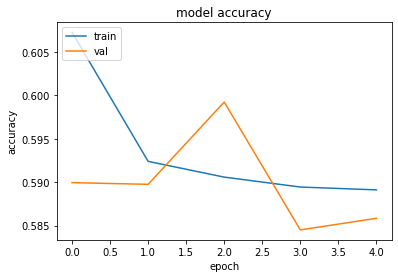

In [55]:
plt.plot(result.history['binary_crossentropy'])
plt.plot(result.history['val_binary_crossentropy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [56]:
model.evaluate(X_test, y_test)

27381/27381 [==============================] - 7s 260us/step - loss: 0.5825 - binary_crossentropy: 0.5825


[0.5824695825576782, 0.5824695825576782]

## Predict

In [57]:
pred = model.predict(X_test)

In [58]:
rce = compute_rce(pred, y_test)
rce

12.854675250748782

In [59]:
average_precision_score(y_test, pred)

0.6381115519822768